In [1]:
# Inspired by: https://github.com/AmazaspShumik/sklearn-bayes
import numpy as np
from scipy.linalg import solve_triangular
from numpy.linalg import LinAlgError
from scipy.linalg import pinvh
from utils import *

class RelevantVectorRegression:
    def __init__(self, 
                 n_iter=300, 
                 tol=1e-3, 
                 verbose=False, 
                 kernel='rbf', 
                 gamma=None, 
                 degree=3, 
                 coef0=1):
        self.n_iter = n_iter
        self.tol = tol
        self.verbose = verbose
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
    def _fit(self, X, y):
        n_samples, n_features = X.shape
        
        XY = np.dot(X.T, y)
        XX = np.dot(X.T, X)
        XXd = np.diag(XX)
        var_y = np.var(y)
        
        if var_y == 0:
            beta = 1e-2
        else:
            beta = 1./var_y
            
        A = np.PINF*np.ones(n_features)
        active = np.zeros(n_features, dtype=np.bool)
        
        # Initialize A and active index
        if np.sum(XXd < np.finfo(np.float32).eps) > 0: # If there is too small value XX diagonal --> start with index 0
            A[0] = np.finfo(np.float32).eps
            active[0] = True
        else:
            proj = XY**2 / XXd
            start = np.argmax(proj)
            active[start] = True
            A[start] = XXd[start]/(proj[start] - var_y)
            
#         for i in range(self.n_iter):
        while True:
            XXa = XX[active, :][:, active]
            XYa = XY[active]
            Aa = A[active]
            
            Mn, Ri, cholesky = self._posterior_distribution(Aa, beta, XXa, XYa)
            if cholesky:
                Sdiag = np.sum(Ri**2, axis=0)
            else:
                Sdiag = np.copy(np.diag(Ri))
                
            s, q, S, Q = self._sparsity_and_quality(XX, XXd, XY, XYa, Aa, Ri, active, beta, cholesky)
            
            # Update beta formula 18
            rss = np.sum((y - np.dot(X[:,active], Mn))**2)
            beta = (n_samples - np.sum(active) + np.sum(Aa*Sdiag)) / (rss + np.finfo(np.float32).eps)
            
            A, converged, active = self._update_precisions(Q, S, q, s, A, active, self.tol, n_samples, True)
            
            if self.verbose:
                print('Iteration: {0}, number of features in the model: {1}'.format(i, np.sum(active)))
            if converged:
                print('Converged')
                break
                
        XXa, XYa, Aa = XX[active,:][:,active], XY[active], A[active]
        Mn, Ri, cholesky = self._posterior_distribution(Aa, beta, XXa, XYa, True)
        self.coef_ = np.zeros(n_features)
        self.coef_[active] = Mn
        self.sigma_ = Ri
        self.active_ = active
        self.lambda_ = A
        self.alpha_ = beta
            
    def _posterior_distribution(self, A, beta, XX, XY, full_covar=False):
        # Formula 12 and 13
        Sinv = beta*XX
        np.fill_diagonal(Sinv, np.diag(Sinv) + A)
        cholesky = True
        try:
            # R*R.T*mean = beta*X.T*Y
            R = np.linalg.cholesky(Sinv)
            Rt_Mn = solve_triangular(R, beta*XY, check_finite=False, lower=True)
            Mn = solve_triangular(R.T, Rt_Mn, check_finite=False, lower=False)
            
            Rinv = solve_triangular(R, np.eye(A.shape[0]), check_finite=False, lower=True)
            if full_covar:
                Ri = np.dot(Rinv.T, Rinv)
                return Mn, Ri, cholesky
            else:
                return Mn, Rinv, cholesky
        except LinAlgError:
            cholesky = False
            Rinv = pinvh(Sinv)
            Mn = beta*np.dot(Sinv, XY)
            return Mn, Rinv, cholesky
        
    def _sparsity_and_quality(self, XX, XXd, XY, XYa, Aa, Ri, active, beta, cholesky):
        bXY = beta*XY
        bXX = beta*XXd
        if cholesky:
            XXR = np.dot(XX[:,active], Ri.T)
            RXY = np.dot(Ri, XYa)
            S = bXX - beta**2 * np.sum(XXR**2, axis=1)
            Q = bXY - beta**2 * np.dot(XXR, RXY)
        else:
            XXa = XX[:,active]
            XS = np.dot(XXa, Ri)
            S = bXX - beta**2 * np.sum(XS*XXa, axis=1)
            Q = bXY - beta**2 * np.dot(XS, XYa)
        
        qi = np.copy(Q)
        si = np.copy(S)
        Qa, Sa = Q[active], S[active]
        qi[active] = Aa*Qa/(Aa - Sa)
        si[active] = Aa*Sa/(Aa - Sa)
        return si, qi, S, Q
    
    def _update_precisions(self, Q, S, q, s, A, active, tol, n_samples, clf_bias):
        deltaL = np.zeros(Q.shape[0])

        theta = q**2 - s
        add = (theta > 0) * (active == False)
        recompute = (theta > 0) * (active == True)
        delete = ~(add + recompute)

        Qadd, Sadd = Q[add], S[add]
        Qrec, Srec, Arec = Q[recompute], S[recompute], A[recompute]
        Qdel, Sdel, Adel = Q[delete], S[delete], A[delete]

        Anew = s[recompute]**2 / (theta[recompute] + np.finfo(np.float32).eps)
        delta_alpha = (1./Anew - 1./Arec)

        deltaL[add] = (Qadd**2 - Sadd)/Sadd + np.log(Sadd/Qadd**2)
        deltaL[recompute] = Qrec**2/(Srec + 1./delta_alpha) - np.log(1 + Srec*delta_alpha)
        deltaL[delete] = Qdel**2/(Sdel - Adel) - np.log(1 - Sdel/Adel)
        deltaL = deltaL/n_samples

        feature_index = np.argmax(deltaL)
        same_features = np.sum(theta[~recompute] > 0) == 0
        no_delta = np.sum(abs(Anew - Arec) > tol) == 0

        converged = False
        if same_features and no_delta:
            converged = True
            return A, converged, active

        if theta[feature_index] > 0:
            A[feature_index] = s[feature_index]**2 / theta[feature_index]
            if active[feature_index] == False:
                active[feature_index] = True
        else:
            if active[feature_index] == True and np.sum(active) >= 2:
                if not (feature_index == 0 and clf_bias):
                    active[feature_index] = False
                    A[feature_index] = np.PINF
        return A, converged, active
        
    def fit(self, X, y, relevant_vectors=None, relevant_ys=None):
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        
        assert X.shape[0] == y.shape[0], 'Does not have same  number of elements between X and y'
        if relevant_vectors is not None:
            assert X.shape[1] == relevant_vectors.shape[1], 'Does not have same number of dimensions between X and relevant_vectors'
            assert relevant_vectors.shape[0] == relevant_ys.shape[0], 'Does not have same number of elements between relevant_vectors and relevant_ys'
            # Stack X with relevant_vectors and y with relevant_ys
            X = np.vstack((relevant_vectors, X))
            y = np.vstack((relevant_ys, y))
            
        self.kernelf = kernel_function(self.kernel)
        K = self.kernelf(X)
        self._fit(K, y)
        
        self.relevant_ = np.where(self.active_ == True)[0]
        if X.ndim == 1:
            self.relevant_vectors_ = X[self.relevant_]
        else:
            self.relevant_vectors_ = X[self.relevant_, :]
            
        print('Number of Relevant Vectors:', self.relevant_vectors_.shape)
        return self
        
    def _kernel_decision_function(self, X):
        K = self.kernelf(X, Y=self.relevant_vectors_)
            
        return K, np.dot(K, self.coef_[self.active_])
        
    def predict_distribution(self, X):
        # Formula 21 and 22
        K, y_hat = self._kernel_decision_function(X)
        var_hat = 1./self.alpha_ + np.sum(np.dot(K, self.sigma_)*K, axis=1)
        print(self.alpha_, K.shape, self.sigma_.shape, self.coef_[self.active_].shape)
        return y_hat, var_hat


In [2]:
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
%matplotlib inline

# parameters
n = 5000

# generate data set
np.random.seed(1)
Xc       = np.ones([n,1])
# Xc[:,0]  = np.linspace(-10, 10, n)
# Yc       = 10 * np.sin(Xc[:,0]) + 0.314 * Xc[:,0] ** 2 + 0.278 * Xc[:,0] + 10.3 + np.random.randn(n)
Xc[:,0]  = np.linspace(-3, 3, n)
Yc = 10*np.sinc(Xc[:,0]) + np.random.randn(n)
X,x,Y,y  = train_test_split(Xc,Yc,test_size = 0.5, random_state = 0)
# train rvr
rvm = RelevantVectorRegression(kernel='rbf')
t1 = time.time()
rvm.fit(X,Y)
t2 = time.time()
y_hat,var     = rvm.predict_distribution(x)
rvm_err   = mean_squared_error(y_hat,y)
rvs       = np.sum(rvm.active_)
print('RVM error on test set is {0}, number of relevant vectors is {1}, time {2}'.format(rvm_err, rvs, t2 - t1))

/home/gdao/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Converged
Number of Relevant Vectors: (10, 1)
0.9947156247904823 (2500, 10) (10, 10) (10,)
RVM error on test set is 1.0104409001262913, number of relevant vectors is 10, time 3.670351982116699


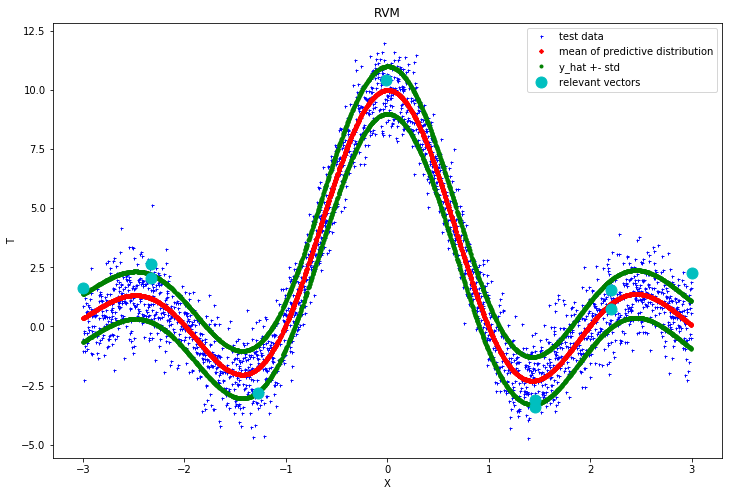

In [3]:
# plot test vs predicted data
plt.figure(figsize = (12,8))
plt.plot(x[:,0],y,'b+',markersize = 3, label = 'test data')
# plt.plot(x[:,0], 10 * np.sin(x[:,0]) + 0.314 * x[:,0] ** 2 + 0.278 * x[:,0] + 10.3 + 0.5, 'gD', markersize = 3, label='true target')
plt.plot(x[:,0],y_hat,"rD", markersize = 3, label = 'mean of predictive distribution')

# plot one standard deviation bounds
plt.plot(x[:,0],y_hat + np.sqrt(var),"go", markersize = 3, label = "y_hat +- std")
plt.plot(x[:,0],y_hat - np.sqrt(var),"go", markersize = 3)
plt.plot(rvm.relevant_vectors_,Y[rvm.active_],'co',markersize = 11,  label = 'relevant vectors')
plt.legend()
plt.title('RVM'); plt.xlabel('X'); plt.ylabel('T')
plt.show()